# Membaca data dan Memberi Label

Membuat fungsi haar yang berisi perintah untuk melakukan deteksi wajah input berupa citra.

In [1]:
import cv2
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def haar(img):
    status = False
    face_roi = [] 

    # Load Haar Cascade classifier for face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 

    # Convert the image to grayscale (required for face detection)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces in the image using the face_cascade
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5) 

    # Draw bounding boxes around the detected faces and display the image
    for (x, y, w, h) in faces:
        # Draw a rectangle around the detected face
        face_roi = img[y:y+h, x:x+w]
        status = True
    return status,face_roi

# Membaca Dataset

In [3]:
#menentukan direktori/folder data citra yang akan dibuka
dirname = '../Dataset/'  

#menentukan ukuran tinggi dan lebar gambar
height = 225
width = 225
dim = (width, height)

#mengumpulkan data citra yang akan dibuka dalam satu array
tampungan_data= [] 
tampungan_label=[]
for path, subdirs, files in os.walk(dirname):
    print(path)
    for name in files:
        img_path = (os.path.join(path, name)) 

        #baca path data
        if (img_path.endswith("png")): #dengan file berekstensi jpg
            img = cv2.imread(img_path) #baca gambar
            
            path_parts = path.split('/')
            # Mengambil elemen terakhir dari path_parts sebagai kata terakhir
            last_word = path_parts[-1]

            #preprocessing data / segentasi  boleh dilakukan disini
            status, gambar_haar = haar(img)
            if(status):
                resized=cv2.resize(gambar_haar,dim, interpolation=cv2.INTER_LINEAR) #resize
                tampungan_data.append(resized/255.0) #menumpuk gambar blur pada array tampungan dan di sampling
                tampungan_label.append(last_word)
    X = np.array(tampungan_data) 
    y = np.array(tampungan_label)

../Dataset/
../Dataset/adnya
../Dataset/farrel


{'adnya': 0, 'farrel': 1}


c:\Users\Devi\miniconda3\envs\Comvis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Devi\miniconda3\envs\Comvis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Devi\miniconda3\envs\Comvis\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


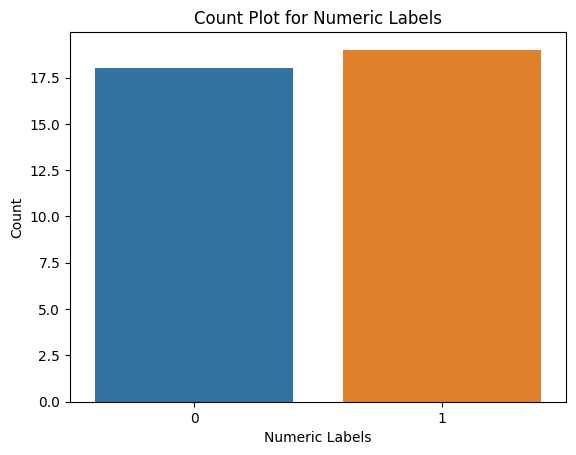

In [4]:
list_label=np.unique(y) #mendapatkan label unik
label_dict = {label: idx for idx, label in enumerate(list_label)} #masukkan dalam list
print(label_dict)
label_numerik = [label_dict[s] for s in y] #ubah kedalam numerik
label_numerik_array = np.array(label_numerik)

# Visualisasikan jumlah dalam plot
sns.countplot(x=label_numerik_array)
plt.xlabel('Numeric Labels')
plt.ylabel('Count')
plt.title('Count Plot for Numeric Labels')
plt.show()  

# simpan dalam file npy untuk labeling
np.save('../weight/label_knn.npy', label_dict)

# Tampilkan Data Hasil Preprocessing

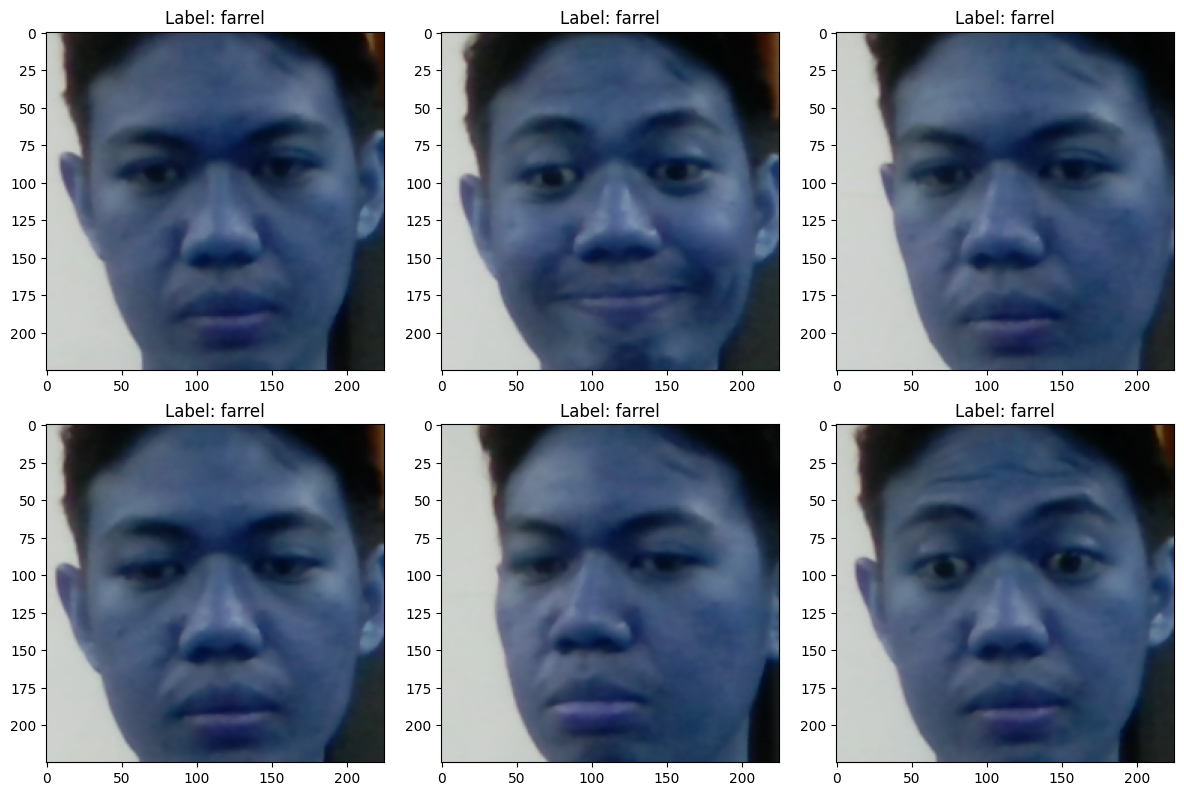

In [5]:
# Randomly select 6 indices from the data
random_indices = np.random.choice(len(X), 6, replace=False)

# Plot the images
plt.figure(figsize=(12, 8))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 3, i+1)
    plt.imshow(X[idx])
    plt.title("Label: " + str(y[idx]))
plt.tight_layout()
plt.show()

# Reshape (Merubah Dimensi dari Data)

In [6]:
print(f"awal {X.shape}")

jml_data = X.shape[0]
h = X.shape[1]
w = X.shape[2]
d = X.shape[3]
flatten  = h*w*d
#untuk shape ML itu 1 dimensi jadi X 3 dimensi harus di reshape jadi 1dimensi
X_1d = X.reshape(jml_data, flatten)

print(f"akhir {X_1d.shape}")  

awal (37, 225, 225, 3)
akhir (37, 151875)


# Train Test Split Data

In [7]:
from sklearn.model_selection import train_test_split #library untuk train test split

#melakukan splitting data
X_train, X_test, y_train, y_test = train_test_split(X_1d, label_numerik_array,test_size=0.20, stratify=y) 
#train size adalah persentase data test yang di-split dengan proporsi label yang sama

print("X_train: "+str(X_train.shape))
print("X_test: "+str(X_test.shape))
print("y_train: "+str(y_train.shape))
print("y_test: "+str(y_test.shape))

X_train: (29, 151875)
X_test: (8, 151875)
y_train: (29,)
y_test: (8,)


# Klasifikasi KNN (K-Fold untuk Model Terbaik)

In [8]:
from sklearn.model_selection import GridSearchCV,StratifiedKFold #melakukan validasi dengan hasil skor akurasi dengan cross validation 

parameters = {'n_neighbors':[1, 3, 5, 7],
             'metric': ['minkowski','euclidean','manhattan']} #masukan parameter yang akan dilakukan 

from sklearn.neighbors import KNeighborsClassifier 

model = KNeighborsClassifier()
# Create the StratifiedKFold cross-validation method
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)


clf = GridSearchCV(model, parameters, verbose=3, cv=stratified_kfold, scoring='accuracy') #panggil gridsearch
clf.fit(X_train,y_train) #train data
best = clf.best_estimator_ #model terbaik
print(clf.best_estimator_) #model terbaik
print(clf.best_score_) #akurasi terbaik

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3] END ...metric=minkowski, n_neighbors=1;, score=0.800 total time=   0.2s
[CV 2/3] END ...metric=minkowski, n_neighbors=1;, score=0.900 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=1;, score=1.000 total time=   0.0s
[CV 1/3] END ...metric=minkowski, n_neighbors=3;, score=0.800 total time=   0.0s
[CV 2/3] END ...metric=minkowski, n_neighbors=3;, score=0.900 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=3;, score=1.000 total time=   0.0s
[CV 1/3] END ...metric=minkowski, n_neighbors=5;, score=1.000 total time=   0.0s
[CV 2/3] END ...metric=minkowski, n_neighbors=5;, score=0.800 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=5;, score=1.000 total time=   0.0s
[CV 1/3] END ...metric=minkowski, n_neighbors=7;, score=0.900 total time=   0.0s
[CV 2/3] END ...metric=minkowski, n_neighbors=7;, score=0.800 total time=   0.0s
[CV 3/3] END ...metric=minkowski, n_neighbors=7;

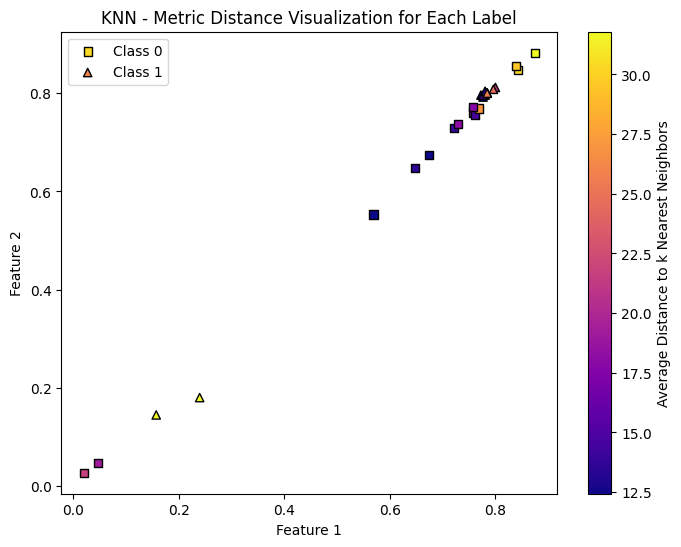

In [9]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

# Buat objek KNeighborsClassifier dan latih model dengan data pelatihan Anda (X_train dan y_train)
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

# Visualisasi metric distances untuk setiap label
plt.figure(figsize=(8, 6))

# Dictionary untuk memetakan label ke bentuk marker yang berbeda
marker_dict = {0: 's', 1: '^', 2: 'o'}

# Sekarang Anda dapat mengakses metode kneighbors
distances, _ = model.kneighbors(X_train)
for label in np.unique(y_train):
    label_indices = np.where(y_train == label)[0]
    # Get the indices of data points belonging to the current label

    label_distances = np.mean(distances[label_indices], axis=1)
    # Get the distances to the k nearest neighbors for data points of the current label

    plt.scatter(X_train[label_indices, 0], X_train[label_indices, 1], c=label_distances, cmap='plasma', edgecolors='k', label=f"Class {label}", marker=marker_dict[label])
    # Plot the distances for the current label with the corresponding marker shape


plt.colorbar(label='Average Distance to k Nearest Neighbors')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("KNN - Metric Distance Visualization for Each Label")
plt.legend()
plt.show()

# Test Model

In [10]:
y_pred = best.predict(X_test) #predict untuk memprediksi data test

# Evaluasi

Confusion Matrix

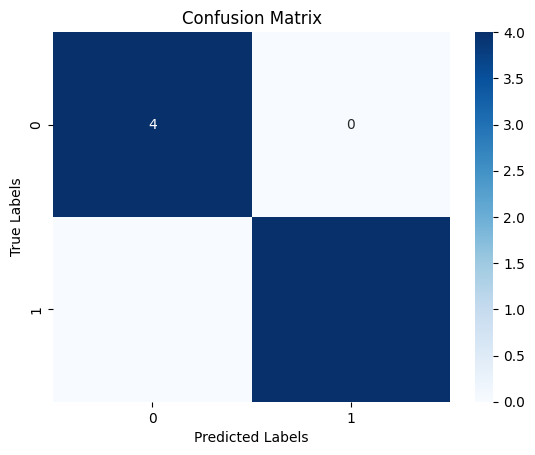

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Performance

In [12]:
print(classification_report(y_test, y_pred)) #evaluasi hasil  

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



# Test Gambar

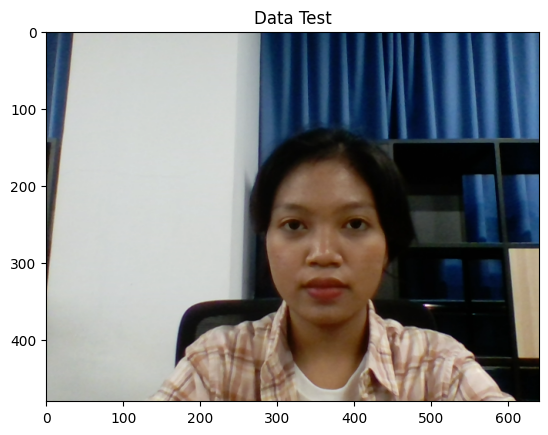

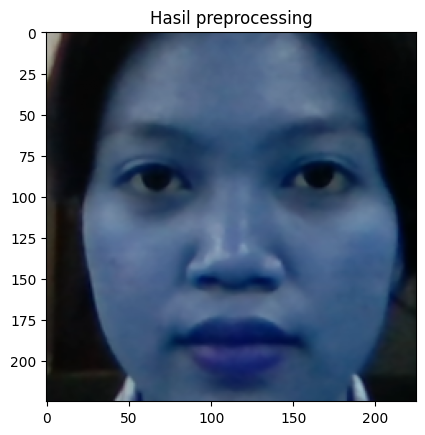

ukuran gambar test (151875,)
nilai probabilitas [[1. 0.]]
adnya = 100.0%
farrel = 0.0%
prediksinya: ['adnya']
The predicted image is : [0] -> ['adnya']


In [13]:
import matplotlib.pyplot as plt
import cv2
import os
import os.path
import numpy as np

url= '../Dataset/adnya/Adnya0.png'
img=cv2.imread(url)
plt.figure()
plt.title("Data Test")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

#pastikan langkah preprocessing yang dilakukan sama dengan data train
status,haarnya=haar(img)
convert = haarnya/255.0
img_resize = cv2.resize(convert,(225,225))
#tampilkan hasil
plt.figure()
plt.title("Hasil preprocessing")
plt.imshow(img_resize)
plt.show()

test=[img_resize.flatten()] #makukan ke list
print(f"ukuran gambar test {img_resize.flatten().shape}") #sama dengan input shape

# Mengecek hasil klasifikasi pada salah satu dataset
probability=best.predict_proba(test)
print(f"nilai probabilitas {probability}") #tampilkan nilai probabilitas tiap kelas



for ind,val in enumerate(label_dict): #mendapatkan nama kelas dan hasil akurasi
    print(f'{val} = {probability[0][ind]*100}%')
    
    
hasil = np.argmax(probability, axis=-1) #mendapatkan kelas dari probabilitas terbaik
key_found = [key for key, value in label_dict.items() if value == hasil] #dapatkan namanya
print(f"prediksinya: {key_found}")
print(f"The predicted image is : {str(hasil)} -> {key_found}")

# Simpan Model 

In [14]:
import pickle
pickle.dump(best, open('../weight/model_haar_knn_optimasi.pkl', 'wb')) #simpan dalam file.pkl

In [15]:
import cv2
import os
import os.path
import numpy as np
from time import sleep
import pickle

def read_model(filename, path=""):
    with open(os.path.join(path, filename), 'rb') as in_name:
        model = pickle.load(in_name)
        return model
    

color = (255, 0, 0)
cap = cv2.VideoCapture(0) # 0 jika kamera
model = read_model("../weight/model_haar_knn_optimasi.pkl", path="") #load model
label_dict = np.load('../weight/label_knn.npy', allow_pickle=True).item() #load label


while (cap.isOpened()):
    ret , frame = cap.read() #baca vidio dengan looping gambar
    if ret:
        face_roi = []# Load Haar Cascade classifier for face detection
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        # Convert the image to grayscale (required for face detection)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the image using the face_cascade
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.5, minNeighbors=5)
        # Draw bounding boxes around the detected faces and display the image
        for (x, y, w, h) in faces:
            # Draw a rectangle around the detected face
            face_roi = frame[y:y+h, x:x+w]
            cv2.rectangle(frame, (x-5, y-5), (x + w+5, y + h+5), (0, 255, 0), 4)#beri rectangle dan beri overlap sebesar 5

            convert = face_roi/255.0 #preprocessing
            muka = cv2.resize(convert, (225,225), interpolation = cv2.INTER_AREA)#wajib sama dengan citra inputan trainer
            cv2.imshow("Detect",muka)
            gambar_flat=[muka.flatten()] #jadikan 1 dimensi
            prediksi= model.predict(gambar_flat) #prediksi
            key_found = [key for key, value in label_dict.items() if value == prediksi] #dapatkan namanya
            cv2.putText(frame, f"Deteksi : {key_found[0]}", (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255),2)
            cv2.imshow("Detect",muka)
        cv2.imshow("Video Original" , frame)
    else:
        print('no video')
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        continue

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

-1